In [48]:
%matplotlib notebook  
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from helpers import conn, db_to_dataframe
from sklearn.preprocessing import StandardScaler
import talib

<IPython.core.display.Javascript object>


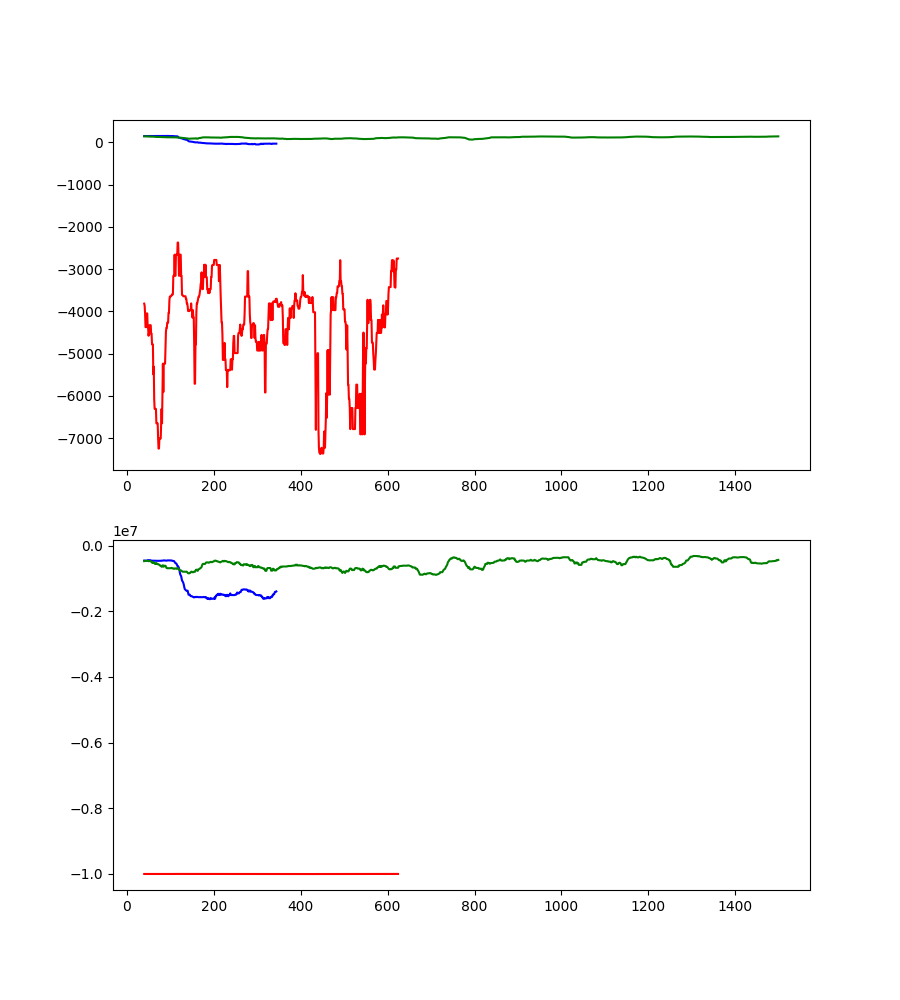

/home/lefnire/anaconda3/envs/btc3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lefnire/anaconda3/envs/btc3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
data = dict(
    b="DQNAgent_network_delta;raw;dbldqn;clip;3lstm256n.2d",
    r="PPOAgent_network_delta;2lstm150n",
    g="DQNAgent_network_delta;dbldqn;clip;2lstm150n.2d"
)

queries = {}
for k, v in data.items():
    queries[k] = """
    select reward, cash+value as total 
    from episodes 
    where agent_name='{}' 
    order by episode asc
    limit 1500
    --offset 400
    """.format(v)

fig = plt.figure(figsize=(9,10))
ax_total = fig.add_subplot(211)
ax_reward = fig.add_subplot(212)
#plt.ion()

fig.show()
fig.canvas.draw()

def prep(arr, period=40):
    if not period: return arr
    #return arr[-limit:]
    return [np.median(arr[i-period:i]) for i,v in enumerate(arr)]
    #return talib.SMA(arr.values, timeperiod=period)
    
def draw():
    dfs = {}
    for k, v in queries.items(): 
        dfs[k] = pd.read_sql_query(v, conn)
    ax_total.clear(); ax_reward.clear()
    rewards, totals = [], []
    for k, v in dfs.items():
        rewards += [prep(v['reward']), k]  # [arr, 'b']
        totals += [prep(v['total']), k]
    ax_reward.plot(*rewards)
    ax_total.plot(*totals)
    #ax_total.set_ylim([-100,200])
    fig.canvas.draw()
    #ax_reward.set_ylim([-3000000,1000])
    
draw()
#while True:
#    draw()
#    time.sleep(10)